# Final Project for University of Michigan's Applied Data Visualization

### By John G Crowley



In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point,Polygon
import numpy as np
import re
import seaborn as sns
import urllib.request
from bs4 import BeautifulSoup
import geopy
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim


%matplotlib inline

## 1.) Beautiful Soup Scraper to get wiki data on Catholic Churches in New Orleans 2018

In [2]:
def wiki_scrape(url,nameindex,addindex,class_type):
    html = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(html,'html.parser')

    tables = soup.find_all('table',{'class':class_type})

    name = []
    address = []

    for table in tables:
        rows = table.find_all('tr')
        header = [th.text.strip() for th in rows[0].find_all('th')]

        for row in rows[1:]:
            cells = row.find_all('td')
            church = cells[nameindex]
            addrs = cells[addindex]

            name.append(church.text.strip())
            address.append(addrs.text.strip())

    #Extract only Church name and Address Headers for GeoCoding
    indices = [nameindex,addindex]
    headers = [header[i] for i in indices]
    headers[0] = 'Church'
    headers[1] = 'Address'
    addresses = [x.replace('\n',' ') for x in address]

    #Turn Headers and Lists into a Dictonary
    wiki_dict = dict([(x,0) for x in headers])
    wiki_dict['Church'] = name
    wiki_dict['Address'] = addresses

    #Turn Dictionary into a DataFrame
    df = pd.DataFrame(wiki_dict)
    return df


## 2.) Prep Function to Geocode addresses 

In [3]:
def geo_df_prep(df):
    #Using Nominatim OSM API, set a delay, GeoCode
    locator = Nominatim(user_agent='johncrowley547@gmail.com')
    geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

    df['location'] = df['Address'].apply(geocode)
    df['Longitude'] = df['location'].apply(lambda loc: loc.longitude if loc else None)
    df['Latitude'] = df['location'].apply(lambda loc: loc.latitude if loc else None)
    return df

## 3.) ------ Gather Data and Clean --------

In [4]:
#Read in 1941 file of Church congregations
df_1941 = pd.read_csv('WPA_1941_FullChurches.csv')
df_1941['Congregation'] = df_1941['Congregation'].str.replace('Roman Catholic Church','Catholic')

#Scrape Catholic Church data for 2020
url_c = 'https://en.wikipedia.org/wiki/List_of_churches_in_the_Roman_Catholic_Archdiocese_of_New_Orleans'
cdf = wiki_scrape(url_c,0,2,'wikitable sortable') 
cdf2 = cdf.iloc[0:34].copy()
cdf2['Address'] = cdf2['Address'].apply(lambda addy: addy + ', ' + 'Louisiana')
cdf2.iloc[0]['Address'] = cdf2.iloc[0]['Address'].replace('Jackson Square French Quarter','New Orleans')

#Scrape Baptist Church data for 2020
url_b = 'https://joinnoba.com/about-noba/our-churches/'
bdf = wiki_scrape(url_b,1,2,'wpgmza_table responsive')
bdf['City'] = bdf['Address'].str.extract(', ([A-Za-z\s]+), LA')
bdf2 = bdf[bdf['City'] == 'New Orleans'].copy()

#Create GeoDataFrames for Each
baptist_df_2020 = geo_df_prep(bdf2)
catholic_df_2020 = geo_df_prep(cdf2)

#Final Clean up
baptist_df_2020['Congregation'] = 'Baptist'
catholic_df_2020['Congregation'] = 'Catholic'
baptist_df_2020 = baptist_df_2020.drop(['City','location'],axis=1)
catholic_df_2020 = catholic_df_2020.drop('location',axis=1)

#Merge
df_2020 = catholic_df_2020.merge(baptist_df_2020,how='outer')

df_2020.head()

,Church,Address,Longitude,Latitude,Congregation
0,St. Louis Cathedral,"615 Pere Antoine Alley, New Orleans, Louisiana",-90.063754,29.957999,Catholic
1,Blessed Francis Xavier Seelos (formerly St. Vi...,"3053 Dauphine St. New Orleans, Louisiana",-90.045917,29.964966,Catholic
2,Our Lady of Guadalupe (The International Shrin...,"411 North Rampart St. New Orleans, Louisiana",-90.070638,29.958439,Catholic
3,Corpus Christi-Epiphany,"2022 St. Bernard Ave. New Orleans, Louisiana",-90.068415,29.976823,Catholic
4,Immaculate Conception,"130 Baronne St. New Orleans, Louisiana",-90.071575,29.953551,Catholic


In [5]:
#2 --------- Find CRS ----------------
#Coordinate Reference System (for longitude and latitude to make our pyplot shapes refer to the real Lat/Lon data)
crs = 'epsg:4326'

In [6]:
#3 --------- Add Geometry points to Df's ----------------
geometry_41 = [Point(xy) for xy in zip(df_1941['Longitude'],df_1941['Latitude'])]
geometry_20 = [Point(xy) for xy in zip(df_2020['Longitude'],df_2020['Latitude'])]

#Generate GeoDataFrames for 2020 and 1941
geo_df_41 = gpd.GeoDataFrame(df_1941,crs=crs,geometry=geometry_41)
geo_df_20 = gpd.GeoDataFrame(df_2020,crs=crs,geometry=geometry_20)

bap_41_size = len(df_1941[(df_1941['Congregation'] == 'Baptist') & (df_1941['Building_Type'] == 'Church')])
cath_41_size = len(df_1941[(df_1941['Congregation'] == 'Catholic') & (df_1941['Building_Type'] == 'Church')])
bap_20_size = len(geo_df_20[geo_df_20['Congregation'] == 'Baptist'])
cath_20_size = len(geo_df_20[geo_df_20['Congregation'] == 'Catholic'])

In [7]:
geo_df_20.head()

,Church,Address,Longitude,Latitude,Congregation,geometry
0,St. Louis Cathedral,"615 Pere Antoine Alley, New Orleans, Louisiana",-90.063754,29.957999,Catholic,POINT (-90.06375 29.95800)
1,Blessed Francis Xavier Seelos (formerly St. Vi...,"3053 Dauphine St. New Orleans, Louisiana",-90.045917,29.964966,Catholic,POINT (-90.04592 29.96497)
2,Our Lady of Guadalupe (The International Shrin...,"411 North Rampart St. New Orleans, Louisiana",-90.070638,29.958439,Catholic,POINT (-90.07064 29.95844)
3,Corpus Christi-Epiphany,"2022 St. Bernard Ave. New Orleans, Louisiana",-90.068415,29.976823,Catholic,POINT (-90.06842 29.97682)
4,Immaculate Conception,"130 Baronne St. New Orleans, Louisiana",-90.071575,29.953551,Catholic,POINT (-90.07158 29.95355)


## 4.)-------- Plot ---------------

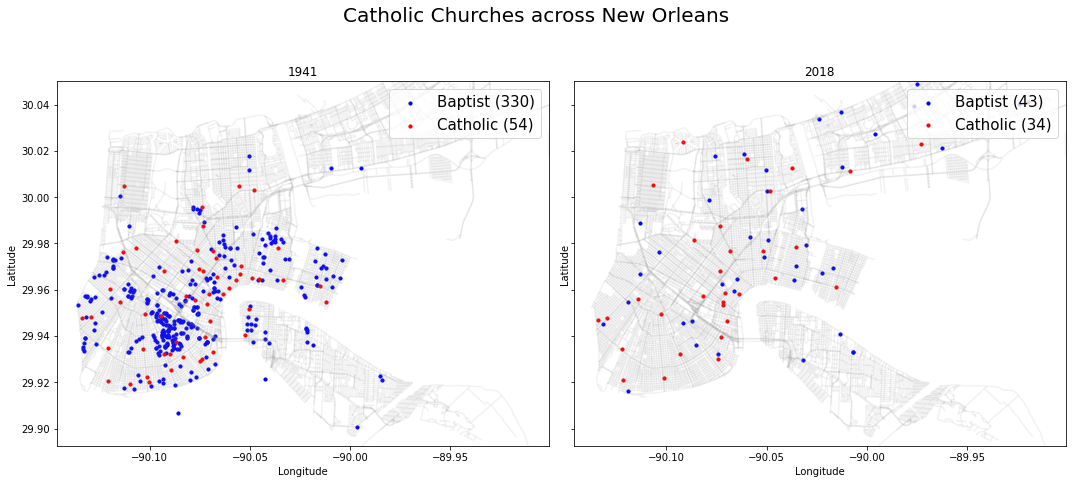

In [8]:

#Plot NOLA Shapefile as base
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7),sharey=True,sharex=True)
nola = gpd.read_file('geo_export_7cd5737d-ae56-42e2-830f-3ceb13a37d29.shp')
nola.plot(ax=ax1,alpha=0.1,color='grey')
nola.plot(ax=ax2,alpha=0.1,color='grey')

#Plot 1941 GeoDataFrame
geo_df_41[(geo_df_41['Congregation'] == 'Baptist') & (geo_df_41['Building_Type'] == 'Church')].plot(ax=ax1,markersize=10,color='blue',marker='o',label='Baptist ({0})'.format(bap_41_size))
geo_df_41[(geo_df_41['Congregation'] == 'Catholic') & (geo_df_41['Building_Type'] == 'Church')].plot(ax=ax1,markersize=10,color='red',marker='o',label='Catholic ({0})'.format(cath_41_size))

#Plot 2020 GeoDataFrame
geo_df_20[geo_df_20['Congregation'] == 'Baptist'].plot(ax=ax2,markersize=10,color='blue',marker='o',label='Baptist ({0})'.format(bap_20_size))
geo_df_20[geo_df_20['Congregation'] == 'Catholic'].plot(ax=ax2,markersize=10,color='red',marker='o',label='Catholic ({0})'.format(cath_20_size))

#Adjust Zoom on NOLA Shape Files
ax1.set_ylim(29.89259035478642, 30.050000000000000)
ax1.set_xlim(-90.1462542677242, -89.90092353227581)
ax1.set_title('1941')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax2.set_ylim(29.89259035478642, 30.050000000000000)
ax2.set_xlim(-90.1462542677242, -89.90092353227581)
ax2.set_title('2018')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

fig.suptitle('Catholic Churches across New Orleans',size=20)
fig.align_labels()


ax1.legend(prop={'size':15},loc=1)
ax2.legend(prop={'size':15},loc=1)
plt.tight_layout()
plt.show()
#plt.savefig('GeoPan_NOLA_Churches_Assn4Project.pdf')

# 5.) Histogram
### Generate Histogram DF of Counts for Catholic v. Baptist over time, inlcuding Population at those years

In [9]:

counts = pd.DataFrame(index=['1941','2018'],columns=['Baptist','Catholic','Population'])

counts.loc['1941']['Population'] = 494000
counts.loc['2018']['Population'] = 388000

counts.loc['1941']['Baptist'] = bap_41_size
counts.loc['1941']['Catholic'] = cath_41_size

counts.loc['2018']['Baptist'] = bap_20_size
counts.loc['2018']['Catholic'] = cath_20_size

# 6.) Pie Chart
### Pie chart for 2018 Percentages of New Orleans Religions
#### -- Illustrating that although Catholic Churches are much fewer per capita than Baptist ones, Catholicism is still 3x the predominant religion in New Orleans, with Baptist as the next most predominant. Note, in our EDA and Cleaning, we even filtered out based on building type, meaning that all 330 Baptist churches are not just church-related buildings or properties

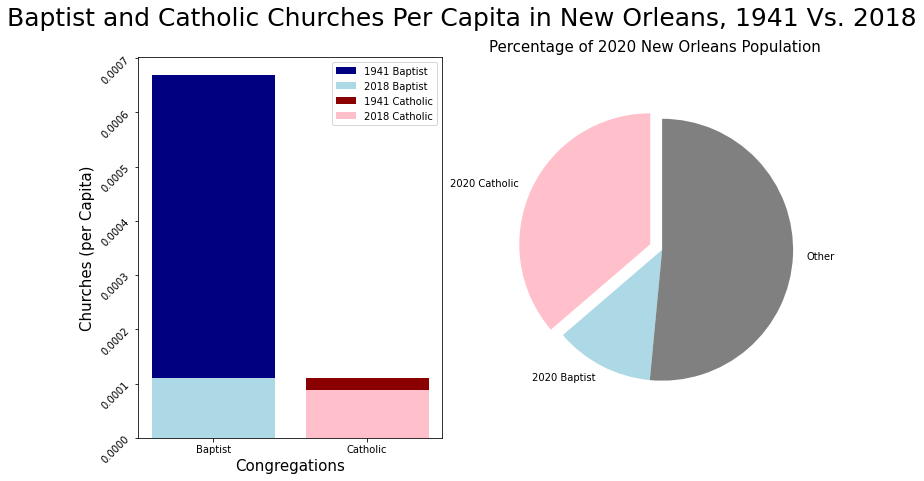

In [10]:
pop_41 = counts.loc['1941']['Population']
pop_18 = counts.loc['2018']['Population']

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,7))

ax1.bar('Baptist',counts.loc['1941']['Baptist']/pop_41,color='navy',label='1941 Baptist')
ax1.bar('Baptist',counts.loc['2018']['Baptist']/pop_18,color='lightblue',label='2018 Baptist')
ax1.bar('Catholic',counts.loc['1941']['Catholic']/pop_41,color='darkred',label='1941 Catholic')
ax1.bar('Catholic',counts.loc['2018']['Catholic']/pop_18,color='pink',label='2018 Catholic')
ax1.set_xlabel('Congregations',size=15)
ax1.set_ylabel('Churches (per Capita)',size=15)
ax1.legend()
for tick in ax1.get_yticklabels():
    tick.set_rotation(45)


labels = ['2020 Catholic', '2020 Baptist', 'Other']
sizes = [36.3,12.2,51.5]
cmap = ['pink','lightblue','gray']
explode = (0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Catholic')

ax2.pie(sizes, explode=explode, labels=labels, colors=cmap, startangle=90)
ax2.axis('equal')
ax2.set_title('Percentage of 2020 New Orleans Population',size=15)

fig.suptitle('Baptist and Catholic Churches Per Capita in New Orleans, 1941 Vs. 2018',size=25)
plt.savefig('Hist_NOLA_Churches_Assn4Project.png')
